In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

## GPR on different data quality

In [2]:
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)

def f_mse(y, y_gt):
    return np.mean((y-y_gt)**2)/np.mean((y_gt)**2)

def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    # DI_ex = IQ_er
    # DI_ex[DI_ex==0] = np.min(DI_ex[DI_ex>0])
    # DI_ex_pos = DI_ex[2*n:]
    # DI_ex_neg = DI_ex[:-2*n]
    # DI_ex = DI_ex[n:-n]

    # DI_ex2_Sq = 4*((DQ_neg*DI_ex_pos)**2 + (DQ_pos*DI_ex_neg)**2 + ((DQ_neg+DQ_pos)*DI_ex)**2)/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    # DI_des = DI_ex*(1+sigma_Q_c**4/4*DI_ex2_Sq/DI_ex**2)
    
    return I_des

def f_log_likelihood(y, y_err, x, x_err, z_list = np.linspace(0, 0, 1), importance = None, index = None):
    """
    likelihood of y in the distribution of x
    """
    ## average over the ovservation uncertainty   
    log_likelihood = 0   
    sum_weight = 0  
    
    if importance is None:
        importance = np.ones(len(y))
    if index is None:
        index = np.arange(len(y))
    
    for z in z_list:
        weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
        y_z = y + y_err*z
        log_likelihood_z = -0.5 * np.sum((((y_z - x)**2 / x_err**2 + np.log(2 * np.pi * x_err**2))*importance)[index])
        log_likelihood += log_likelihood_z*weight_z
        sum_weight += weight_z
    log_likelihood = log_likelihood/sum_weight
    return log_likelihood



## SDS

In [3]:
filename_list = [f'SDS_5mgmL_20C_4m_fbt_0_{i:0.0f}_Iq.dat' for i in  np.concatenate([np.linspace(1, 9, 9), np.linspace(10, 30, 5), np.linspace(60, 120, 3), np.linspace(240, 720, 5)])]
label_list = [f'time_0_{i:0.0f}' for i in np.concatenate([np.linspace(1, 9, 9), np.linspace(10, 30, 5), np.linspace(60, 120, 3), np.linspace(240, 720, 5)])]
time_list = np.concatenate([np.linspace(1, 9, 9), np.linspace(10, 30, 5), np.linspace(60, 120, 3), np.linspace(240, 720, 5)])

data_list = []

for i_file, filename in enumerate(filename_list):
    data = np.loadtxt('./data/EQSANS/SDS/'+filename, skiprows=2)
    data_list.append(data)

In [4]:
# The smooth data
I_data_good = np.zeros(data_list[0].shape[0])
total_time = 0
for i_t, time in enumerate(time_list):
    index_data_good = i_t
    data = data_list[index_data_good]
    q_data_good = data[:, 0]
    I_data_good += data[:, 1]*time
    total_time += time
    I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
    # Scan through each data point, if find zero, assign that value as previous data
    for i in range(1, len(I_err_data_good)):
        if I_err_data_good[i] == 0:
            I_err_data_good[i] = I_err_data_good[i - 1]
            
I_data_good = I_data_good/total_time

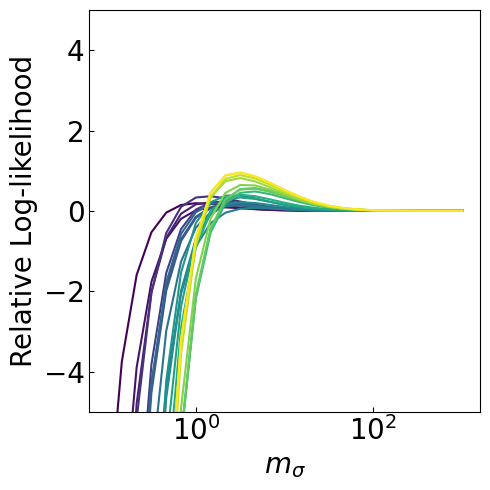

In [5]:
n_trial = 1
filter_size = 0.5
I_bg = 0.001
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):
    
    ax = plt.subplot(1, 1, 1)

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = 21
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.4)|(q_data < 0.015)  
        index_outlier = (q_data < 0.4)&(q_data > 0.015)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(5):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.225
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_data)
            y_gt = f_I(I_data_good)
            y_bg = f_I(I_q_gf)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = I_err_data
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y[index_outlier]**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q_data
            q_s = q_data

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        importance = np.where((q_data > 0.014)&(q_data < 0.42), 1, 0)
        # importance = None
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)
    
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

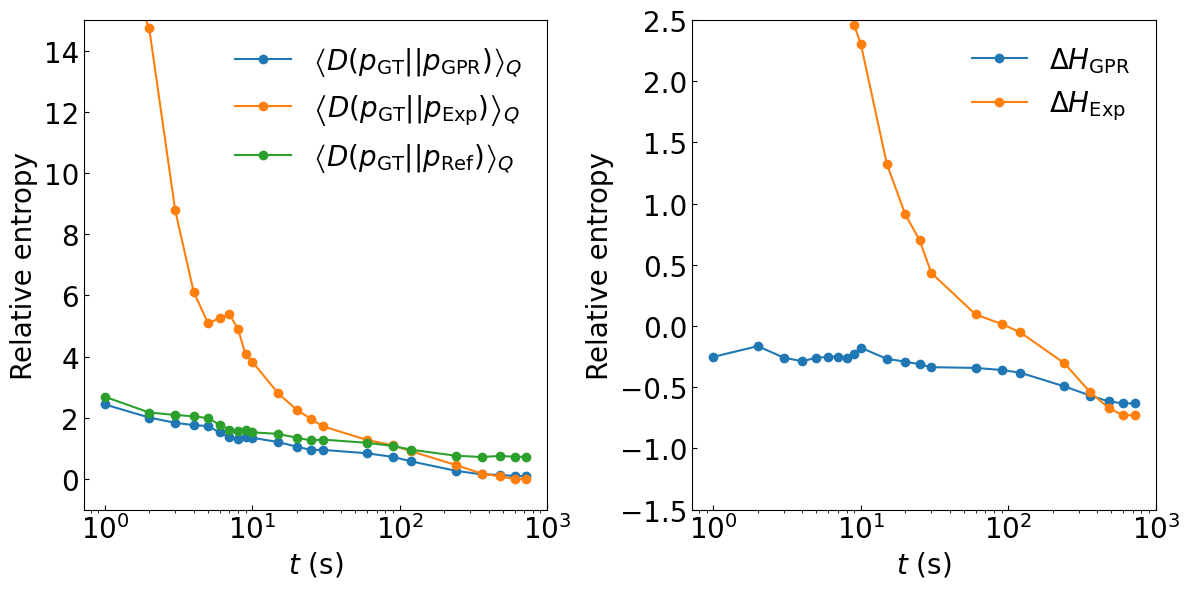

In [6]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gain as a function of n_sample
ax = axs[0]
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(time_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(time_list)
ax.set_xscale('log')
# ax.set_xscale('log')
ax.set_ylim([-1, 15])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# Plot the gain as a function of n_sample
ax = axs[1]
ax.plot(time_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
ax.plot(time_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(time_list)
ax.set_xscale('log')
ax.set_xscale('log')
ax.set_ylim([-1.5, 2.5])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

plt.tight_layout()

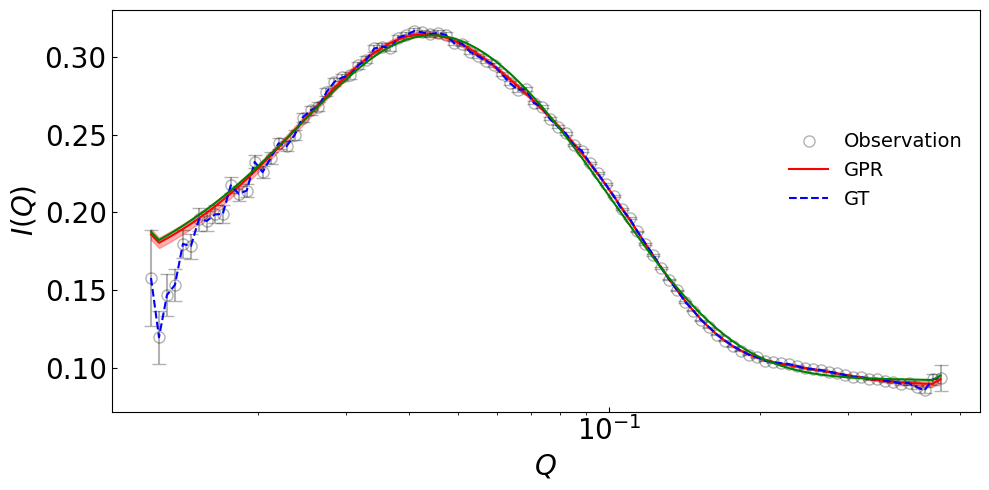

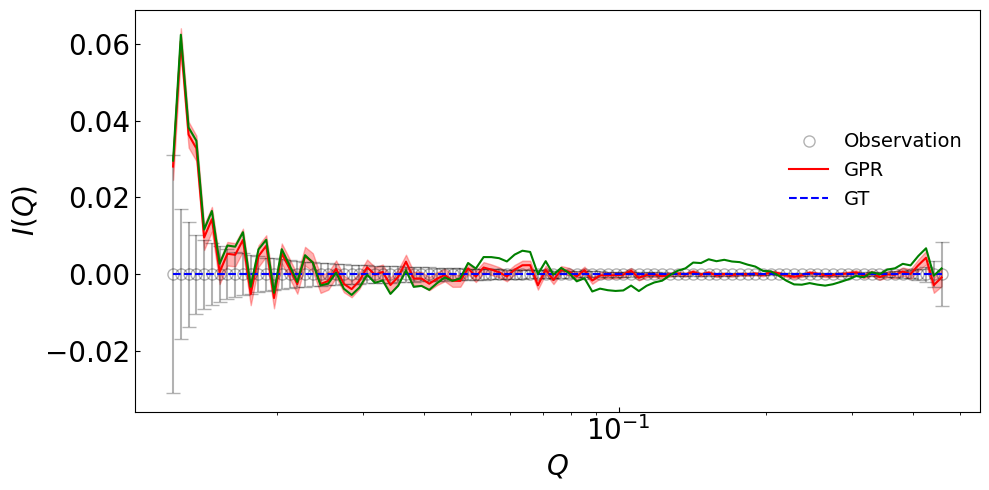

In [7]:
y_ref = y_gt

# plot the GPR result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y_data, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
ax.errorbar(q_x, y_data, yerr=y_err_pixel, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

ax.plot(q_x, y_gt , '--b', label='GT')

ax.plot(q_x, y_bg, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([5e-2, 2e1])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=14, loc='right', bbox_to_anchor=(1, 0.6))
plt.tight_layout()

# plot the GPR result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg-y_ref, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
ax.errorbar(q_x, y + y_bg-y_ref, yerr=y_err_pixel, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, mu_s + y_bg-y_ref, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg-y_ref, mu_s + std_s + y_bg-y_ref, color='r', alpha=0.3)

ax.plot(q_x, y_gt-y_ref , '--b', label='GT')

ax.plot(q_x, y_bg-y_ref, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([5e-2, 2e1])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=14, loc='right', bbox_to_anchor=(1, 0.6))
plt.tight_layout()

## check intermediate times

In [8]:
# n_trial = 1
# filter_size = 0.5
# I_bg = 0.001
# use_log_I = False
# use_log_Q = True

# # Transformations on Q and I(Q)
# f_Q = lambda q: q
# f_inv_Q = lambda fq: fq
# if use_log_Q:
#     f_Q = lambda q: np.log(q)
#     f_inv_Q = lambda fq: np.exp(fq)


# f_I = lambda I: I
# f_inv_I = lambda fI: fI
# # if use_log_I:
# #     f_I = lambda I: np.log(I+I_bg)
# #     f_inv_I = lambda fI: np.exp(fI)-I_bg
# if use_log_I:
#     f_I = lambda I: f_loglin(I, x_c=I_bg*2)
#     f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

# def get_viridis_color(value):
#     cmap = plt.get_cmap('viridis')
#     return cmap(value)

# fig = plt.figure(figsize=(5, 5))

# # n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# # n_sample_list = np.linspace(1000, 20000, 10)
# n_sample_list = np.logspace(1, 7, 13)

# # list_L_gpr = []
# # list_L_exp = []
# # list_mse_gpr = []
# # list_mse_exp = []
# # list_G_acc_gpr = []
# # list_G_acc_exp = []
# # list_G_m = []
# for i_t, time in enumerate([time_list[0]]):
    
#     ax = plt.subplot(1, 1, 1)

#     color = get_viridis_color(i_t/(len(time_list)-1))


#     log_likelihood_gt_exp = 0
#     log_likelihood_gt_gpr = 0
#     mse_exp = 0
#     mse_gpr = 0
#     G_acc_gpr = 0
#     G_acc_exp = 0
#     G_m = 0
    
#     for i_trial in range(n_trial):
#         # The noisy data
#         index_data = i_t
#         data = data_list[index_data]
#         q_data = data[:, 0]
#         I_data = data[:, 1]
#         I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
#         # Scan through each data point, if find zero, assign that value as previous data
#         for i in range(1, len(I_err_data)):
#             if I_err_data[i] == 0:
#                 I_err_data[i] = I_err_data[i - 1]
                
#         # The smooth data
#         index_data_good = 21
#         data = data_list[index_data_good]
#         q_data_good = data[:, 0]
#         I_data_good = data[:, 1]
#         I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
#         # Scan through each data point, if find zero, assign that value as previous data
#         for i in range(1, len(I_err_data_good)):
#             if I_err_data_good[i] == 0:
#                 I_err_data_good[i] = I_err_data_good[i - 1]
        
#         index_outlier_sm = (q_data > 0.35)|(q_data < 0.015)  
#         index_outlier = (q_data < 0.5)
        
#         I_q_gf = np.zeros_like(q_data)
#         for i_iterate in range(5):
#             I_q_gf_i = np.zeros_like(q_data)
#             I_iterate = I_data - I_q_gf
#             for i in range(len(q_data)):
#                 weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
#                 weight_list[index_outlier_sm] = 0
#                 weight_list = weight_list/np.sum(weight_list)
#                 I_q_gf_i[i] = np.sum(I_iterate*weight_list)
#             # n_sm = 1
#             # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
#             I_q_gf = I_q_gf + I_q_gf_i

#         ## GPR
#         sigma_list = np.logspace(-1, 3, 25)
#         log_likelihood_list = []
#         for sigma in sigma_list:
#             lmbda = 0.225
#             # sigma = 10

#             ## define kernel function
#             y_data = f_I(I_data)
#             y_gt = f_I(I_data_good)
#             y_bg = f_I(I_q_gf)
#             # y_bg = y_gt
#             y = y_data-y_bg

#             # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
#             y_err_pixel = I_err_data
#             y_err = y_err_pixel
#             if use_log_I:
#                 y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg)

#             y_bg = y_bg[index_outlier]
#             y_gt = y_gt[index_outlier]
#             y = y[index_outlier]
#             y_err = y_err[index_outlier]
#             y_data = y_data[index_outlier]

#             # scale by a factor to check whether error estimation is correct
#             m_factor = 1
#             y_bg = y_bg*m_factor
#             y_gt = y_gt*m_factor
#             y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
#             y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
#             y_data = y_data*m_factor
#             sig_var = np.mean(y**2)
            
#             # fluctuations of the prior distribution
#             prior_sigma = np.sqrt(sig_var)
#             # prior_sigma = np.sqrt(np.mean(y_err**2))
#             # prior_sigma = np.sqrt(y_err**2+sig_var) 

#             q_x = q_data[index_outlier]
#             q_s = q_data[index_outlier]

#             def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
#                 if std_1 is None:
#                     std_1 = np.ones_like(q1)
#                 if std_2 is None:
#                     std_2 = np.ones_like(q2)
#                 K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
#                 return K
            
#             f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
#             K_sigma = np.diag(f_y_err(y_err))
#             # K_sigma = sigma**2*np.eye(len(q_x))
#             K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
#             K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
#             k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

#             L = np.linalg.cholesky(K_xx)
#             alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
#             v = np.linalg.solve(L, K_xs)
#             mu_s = K_xs.T @ alpha
#             cov_s = k_ss - v.T @ v
#             var_s = np.diag(cov_s)*prior_sigma**2
#             std_s = np.sqrt(var_s)

#             # evaluate the log likelihood
#             log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
#             log_likelihood_list.append(log_likelihood)
            
#         log_likelihood_list = np.array(log_likelihood_list)
#         log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

#         ax.plot(sigma_list, log_likelihood_list, '-', color=color)
#         ax.set_xscale('log')
#         ax.set_ylim([-5, 5])
#         ax.tick_params(direction='in', labelsize=20)
#         ax.set_xlabel(r'$m_\sigma$', fontsize=20)
#         ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

#         sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
#         # ax.legend(frameon=False, fontsize=13, ncol=2)
#         plt.tight_layout()

#         # GPR with best sigma
#         f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
#         K_sigma = np.diag(f_y_err(y_err))
#         # K_sigma = sigma**2*np.eye(len(q_x))
#         K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
#         K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
#         k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

#         L = np.linalg.cholesky(K_xx)
#         alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
#         v = np.linalg.solve(L, K_xs)
#         mu_s = K_xs.T @ alpha
#         cov_s = k_ss - v.T @ v
#         var_s = np.diag(cov_s)*prior_sigma**2
#         std_s = np.sqrt(var_s)

In [9]:
# # The smooth data
# index_data_med = 17
# data = data_list[index_data_med]
# q_data_med = data[:, 0]
# I_data_med = data[:, 1]
# I_err_data_med = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
# # Scan through each data point, if find zero, assign that value as previous data
# for i in range(1, len(I_err_data_med)):
#     if I_err_data_med[i] == 0:
#         I_err_data_med[i] = I_err_data_med[i - 1]

In [10]:
# print(time_list[index_data_med])

In [11]:
# y_ref = y_gt

# I_gp = f_inv_I(mu_s + y_bg)
# I_gp_err = std_s
# if use_log_I:
#     I_gp_err = std_s/f_loglin_deriv(I_data[index_outlier], x_c=I_bg*2)
    
# I_bg = f_inv_I(y_bg)

# I_ref_plot = I_data_good

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_data, I_data, 'ok', markersize=8, fillstyle='none', label=r'$I_{t=1}$', alpha=0.3) 
# ax.errorbar(q_data, I_data, yerr=I_err_data, fmt='none', ecolor='k', capsize=5, alpha=0.3)

# ax.fill_between(q_s, I_gp - I_gp_err, I_gp + I_gp_err, color='r', alpha=0.3)



# # ax.plot(q_data, I_data_med , 'sc', label=r'$I_{t=240}$', fillstyle='none')
# # ax.errorbar(q_data, I_data_med, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

# ax.plot(q_data, I_data_good , 'xb', label=r'$I_{t=720}$')
# ax.errorbar(q_data, I_data_good, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)

# ax.plot(q_data, I_q_gf, '-g', label='BG')
# ax.plot(q_s, I_gp, '-r', label='GPR')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([0.05, 1])
# # ax.set_ylim([0, 5])

# ax.legend(frameon=False, fontsize=16, loc='lower center', bbox_to_anchor=(0.75, 0.6))
# plt.tight_layout()

# y_ref = y_gt

# I_gp = f_inv_I(mu_s + y_bg)
# I_gp_err = std_s
# if use_log_I:
#     I_gp_err = std_s/f_loglin_deriv(I_data[index_outlier], x_c=I_bg*2)
    
# I_bg = f_inv_I(y_bg)

# I_ref_plot = I_data_good

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_data, I_data-I_ref_plot, 'ok', markersize=8, fillstyle='none', label=r'$I_{t=1}$', alpha=0.3) 
# ax.errorbar(q_data, I_data-I_ref_plot, yerr=I_err_data, fmt='none', ecolor='k', capsize=5, alpha=0.3)

# ax.fill_between(q_s, I_gp - I_gp_err-I_ref_plot, I_gp + I_gp_err-I_ref_plot, color='r', alpha=0.3)



# ax.plot(q_data, I_data_med-I_ref_plot , 'sc', label=r'$I_{t=240}$', fillstyle='none')
# ax.errorbar(q_data, I_data_med-I_ref_plot, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

# ax.plot(q_data, I_data_good-I_ref_plot , 'xb', label=r'$I_{t=720}$')
# ax.errorbar(q_data, I_data_good-I_ref_plot, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)

# # ax.plot(q_data, I_q_gf, '-g', label='BG')
# ax.plot(q_s, I_gp-I_ref_plot, '-r', label='GPR')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# # ax.set_yscale('log')
# ax.set_ylim([-0.25, 0.25])
# # ax.set_ylim([0, 5])

# ax.legend(frameon=False, fontsize=16, loc='lower center', bbox_to_anchor=(0.75, 0.6))
# plt.tight_layout()

In [12]:
# y_ref = y_gt

# I_gp = f_inv_I(mu_s + y_bg)
# I_gp_err = std_s
# if use_log_I:
#     I_gp_err = std_s/f_loglin_deriv(I_data[index_outlier], x_c=I_bg*2)
    
# I_bg = f_inv_I(y_bg)

# I_ref_plot = I_bg

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# # ax.plot(q_data, I_data, 'ok', markersize=8, fillstyle='none', label=r'$I_{t=1}$', alpha=0.3) 
# # ax.errorbar(q_data, I_data, yerr=I_err_data, fmt='none', ecolor='k', capsize=5, alpha=0.3)

# # ax.fill_between(q_s, I_gp - I_gp_err, I_gp + I_gp_err, color='r', alpha=0.3)



# ax.plot(q_data, I_data_med , 'sc', label=r'$I_{t=240}$', fillstyle='none')
# ax.errorbar(q_data, I_data_med, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

# ax.plot(q_data, I_data_good , 'xb', label=r'$I_{t=720}$')
# ax.errorbar(q_data, I_data_good, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)

# # ax.plot(q_data, I_q_gf, '-g', label='BG')
# # ax.plot(q_s, I_gp, '-r', label='GPR')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([0.05, 1])
# # ax.set_ylim([0, 5])

# ax.legend(frameon=False, fontsize=16, loc='lower center', bbox_to_anchor=(0.75, 0.6))
# plt.tight_layout()

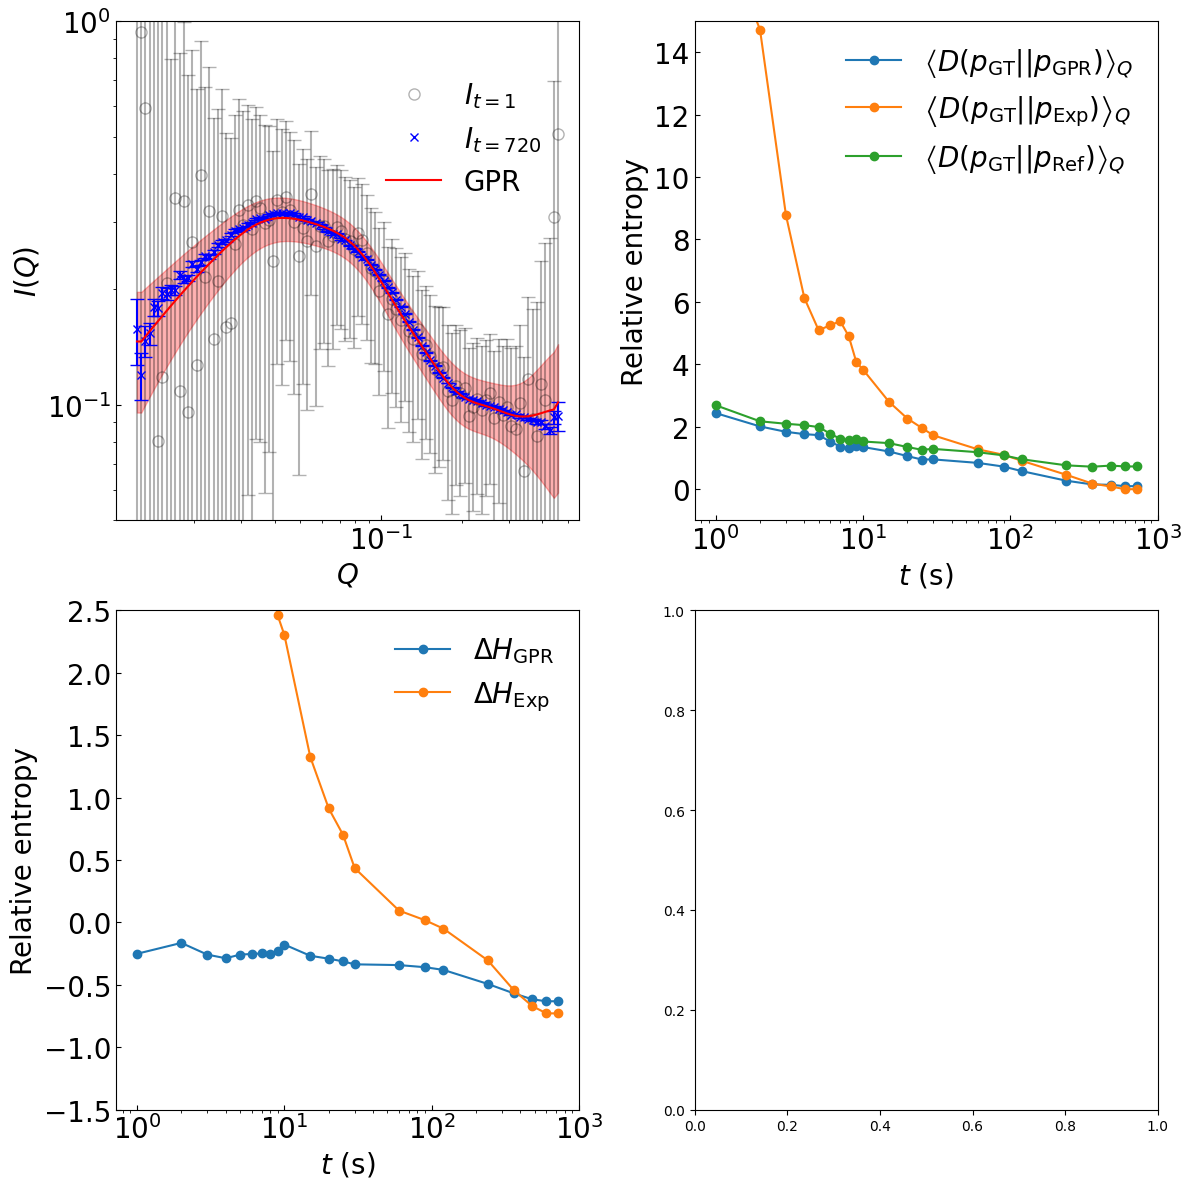

In [13]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# plot the GPR result
ax = axs[0,0]
i_time_exp = 0
I_gp = list_I_mean_gp[i_time_exp]
I_gp_err = list_I_std_gp[i_time_exp]

data = data_list[i_time_exp]
q_data = data[:, 0]
I_exp = data[:, 1]
I_exp_err = data[:, 2]

ax.plot(q_data, I_exp, 'ok', markersize=8, fillstyle='none', label=r'$I_{t=1}$', alpha=0.3) 
ax.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)

ax.fill_between(q_s, I_gp - I_gp_err, I_gp + I_gp_err, color='r', alpha=0.3)

# ax.plot(q_data, I_data_med , 'sc', label=r'$I_{t=240}$', fillstyle='none')
# ax.errorbar(q_data, I_data_med, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

ax.plot(q_data, I_data_good , 'xb', label=r'$I_{t=720}$')
ax.errorbar(q_data, I_data_good, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)

# ax.plot(q_data, I_q_gf, '-g', label='BG')
ax.plot(q_s, I_gp, '-r', label='GPR')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.05, 1])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=20, loc='lower center', bbox_to_anchor=(0.75, 0.6))

# Plot the gain as a function of n_sample
ax = axs[0,1]
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(time_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(time_list)
ax.set_xscale('log')
# ax.set_xscale('log')
ax.set_ylim([-1, 15])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# Plot the gain as a function of n_sample
ax = axs[1,0]
ax.plot(time_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
ax.plot(time_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(time_list)
ax.set_xscale('log')
ax.set_xscale('log')
ax.set_ylim([-1.5, 2.5])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# plot the intermediate results
ax = axs[1,1]
# I_ref_plot = (I_data_good+I_data_med)/2*0
# # ax.fill_between(q_s, I_gp - I_gp_err-I_ref_plot, I_gp + I_gp_err-I_ref_plot, color='r', alpha=0.3)

# ax.plot(q_data, I_data_med-I_ref_plot, 'sc', label=r'$I_{t=240}$', fillstyle='none')
# ax.errorbar(q_data, I_data_med-I_ref_plot, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

# ax.plot(q_data, I_data_good-I_ref_plot, 'xb', label=r'$I_{t=720}$')
# ax.errorbar(q_data, I_data_good-I_ref_plot, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)
# # ax.plot(q_s, I_gp-I_ref_plot, '-r', label='GPR')

# # ax.plot(q_data, I_q_gf, '-g', label='BG')
# # ax.plot(q_s, I_gp, '-r', label='GPR')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([0.05, 1])
# # ax.set_ylim([-0.05, 0.05])

# ax.legend(frameon=False, fontsize=20, loc='lower center', bbox_to_anchor=(0.75, 0.6))

plt.tight_layout()

/tmp/ipykernel_1387585/1943445633.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-0.2, 1000], [2.5, 2.5], '--k', color='k', label = r'$t_\mathrm{Exp}$')
/tmp/ipykernel_1387585/1943445633.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1,1], [-1, 22], '--k', color='k', label = r'$t_\mathrm{Exp}$')


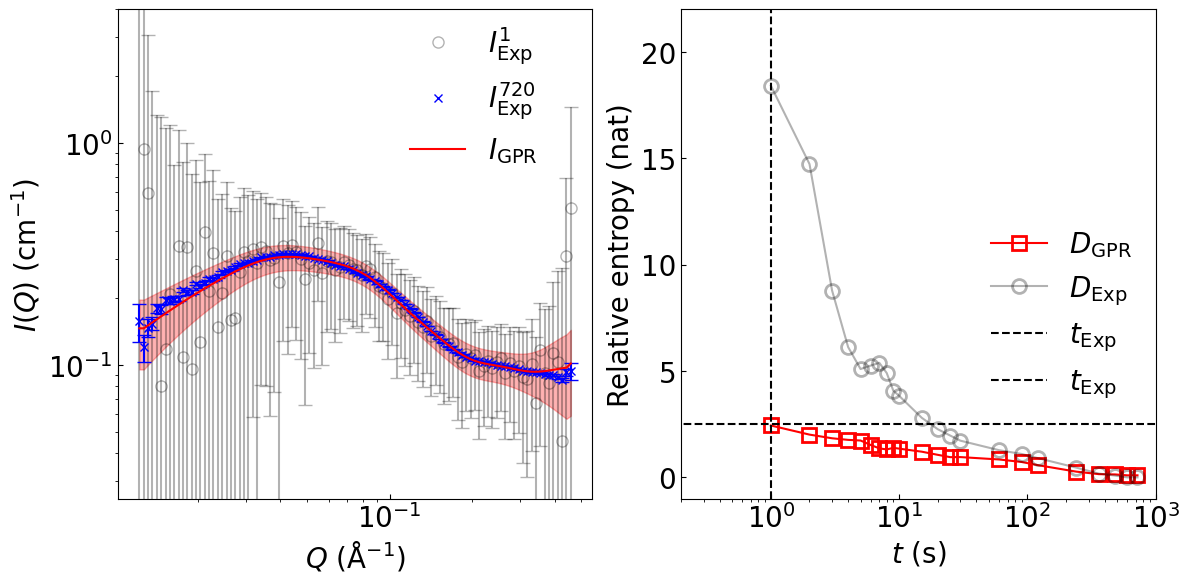

In [21]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot the GPR result
ax = axs[0]
i_time_exp = 0
I_gp = list_I_mean_gp[i_time_exp]
I_gp_err = list_I_std_gp[i_time_exp]

data = data_list[i_time_exp]
q_data = data[:, 0]
I_exp = data[:, 1]
I_exp_err = data[:, 2]

ax.plot(q_data, I_exp, 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}^{1}$', alpha=0.3) 
ax.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)

ax.fill_between(q_s, I_gp - I_gp_err, I_gp + I_gp_err, color='r', alpha=0.3)

# ax.plot(q_data, I_data_med , 'sc', label=r'$I_{t=240}$', fillstyle='none')
# ax.errorbar(q_data, I_data_med, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

ax.plot(q_data, I_data_good , 'xb', label=r'$I_\mathrm{Exp}^{720}$')
ax.errorbar(q_data, I_data_good, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)

# ax.plot(q_data, I_q_gf, '-g', label='BG')
ax.plot(q_s, I_gp, '-r', label=r'$I_\mathrm{GPR}$')

ax.set_xlabel(r'$Q \ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ (\mathrm{cm}^{-1})$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.025, 4])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=20, loc='lower center', bbox_to_anchor=(0.75, 0.63))

# Plot the gain as a function of n_sample
ax = axs[1]
# ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{Exp}}^{720}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
# ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{Exp}}^{720}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-s', color='r', label=r'$D_{\mathrm{GPR}}$', fillstyle='none', ms=10, markeredgewidth=2)
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='k', label=r'$D_{\mathrm{Exp}}$', alpha=0.3, fillstyle='none', ms=10, markeredgewidth=2)
# ax.plot(time_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')

ax.set_xticks(time_list)
ax.set_xscale('log')
# ax.set_xscale('log')
ax.set_ylim([-1, 25])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'Relative entropy (nat)', fontsize=20)
ax.plot([-0.2, 1000], [2.5, 2.5], '--k', color='k', label = r'$t_\mathrm{Exp}$')
ax.plot([1,1], [-1, 22], '--k', color='k', label = r'$t_\mathrm{Exp}$')
ax.set_ylim([-1, 22])
ax.set_xlim([0.2, 1000])
ax.legend(frameon=False, fontsize=20, bbox_to_anchor=[0.6, 0.15, 0, 0])

def f_not_used():
    '''
        fold unused code
    '''
    # Plot time required for GPR to reach the same relative entropy as the experimental data
    # interpolate relative entropy
    # f_interp_exp = interp1d(list_G_acc_exp[-1]-list_G_acc_exp, time_list, kind='linear', fill_value='extrapolate')

    # time_exp = np.zeros_like(time_list)
    # for i in range(len(list_G_acc_gpr)):
    #     H_gpr_gt_i = list_G_acc_exp[-1]-list_G_acc_gpr[i]
    #     time_exp[i] = f_interp_exp(H_gpr_gt_i)

    # ax = axs[2]
    # ax.plot(time_list, time_exp, 'or', color='C1')
    # ax.plot([1, 1000], [1, 1000], '--k', color='C0')
    # ax.legend(frameon=False, fontsize=20)
    # ax.set_xticks(time_list)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_xlim([1, 1000])
    # ax.set_ylim([1, 1000])
    # ax.tick_params(direction='in', labelsize=20)
    # # ax.tick_params(axis='x', direction='in', labelsize=18)
    # ax.set_xlabel(r'$t_\mathrm{GPR} \ (\mathrm{s})$', fontsize=20)
    # ax.set_ylabel(r'$t_\mathrm{Exp} \ (\mathrm{s})$', fontsize=20)

    # f_interp_gpr = interp1d(list_G_acc_exp[-1]-list_G_acc_gpr, time_list, kind='linear', fill_value='extrapolate')

    # time_gpr = np.zeros_like(time_list)
    # for i in range(len(list_G_acc_exp)):
    #     H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    #     time_gpr[i] = f_interp_gpr(H_exp_gt_i)

    # ax = axs[2]
    # ax.plot(time_list, time_gpr, 'or', color='C0')
    # ax.plot([1, 1000], [1, 1000], '--k', color='C1')
    # ax.legend(frameon=False, fontsize=20)
    # ax.set_xticks(time_list)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_xlim([1, 1000])
    # ax.set_ylim([1, 1000])
    # ax.tick_params(direction='in', labelsize=20)
    # # ax.tick_params(axis='x', direction='in', labelsize=18)
    # ax.set_xlabel(r'$t_\mathrm{Exp} \ (\mathrm{s})$', fontsize=20)
    # ax.set_ylabel(r'$t_\mathrm{GPR} \ (\mathrm{s})$', fontsize=20)

    # # plot the intermediate results
    # ax = axs[1,1]
    # I_ref_plot = (I_data_good+I_data_med)/2*0
    # # ax.fill_between(q_s, I_gp - I_gp_err-I_ref_plot, I_gp + I_gp_err-I_ref_plot, color='r', alpha=0.3)

    # ax.plot(q_data, I_data_med-I_ref_plot, 'sc', label=r'$I_{t=240}$', fillstyle='none')
    # ax.errorbar(q_data, I_data_med-I_ref_plot, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

    # ax.plot(q_data, I_data_good-I_ref_plot, 'xb', label=r'$I_{t=720}$')
    # ax.errorbar(q_data, I_data_good-I_ref_plot, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)
    # # ax.plot(q_s, I_gp-I_ref_plot, '-r', label='GPR')

    # # ax.plot(q_data, I_q_gf, '-g', label='BG')
    # # ax.plot(q_s, I_gp, '-r', label='GPR')

    # ax.set_xlabel(r'$Q$', fontsize=20)
    # ax.set_ylabel(r'$I(Q)$', fontsize=20)

    # ax.tick_params(direction='in', labelsize=20)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_ylim([0.05, 1])
    # # ax.set_ylim([-0.05, 0.05])

    # ax.legend(frameon=False, fontsize=20, loc='lower center', bbox_to_anchor=(0.75, 0.6))

plt.tight_layout()

/tmp/ipykernel_1387585/3746876903.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot(time_list, time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
/tmp/ipykernel_1387585/3746876903.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1, 1000], [1, 1000], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')


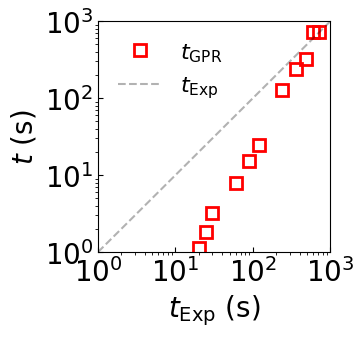

In [15]:
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(time_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(time_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(time_list, time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([1, 1000], [1, 1000], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')

ax.set_xticks(time_list)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1, 1000])
ax.set_ylim([1, 1000])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t_\mathrm{Exp} \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.legend(frameon=False, fontsize=16)

/tmp/ipykernel_1387585/1465630194.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot(time_list, time_gpr/time_list, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
/tmp/ipykernel_1387585/1465630194.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1, 1000], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')


Text(0, 0.5, '$t_\\mathrm{GPR}/t_\\mathrm{Exp}$')

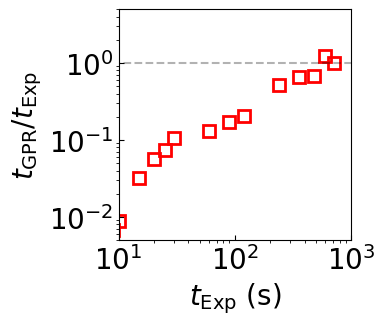

In [16]:
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(time_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(time_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(time_list, time_gpr/time_list, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([1, 1000], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')

ax.set_xticks(time_list)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10, 1000])
ax.set_ylim([5e-3, 5])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t_\mathrm{Exp} \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'$t_\mathrm{GPR}/t_\mathrm{Exp}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')

/tmp/ipykernel_1387585/3949156345.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_gpr/time_list, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
/tmp/ipykernel_1387585/3949156345.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')


Text(0, 0.5, '$t_\\mathrm{GPR}/t_\\mathrm{Exp}$')

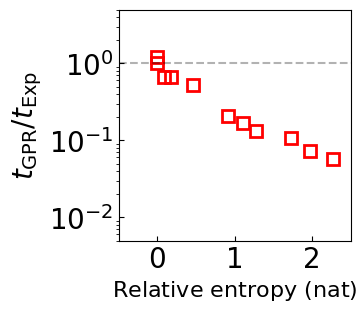

In [17]:
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(time_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(time_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_gpr/time_list, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')

ax.set_xticks([0,1,2])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([5e-3, 5])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$\mathrm{Relative\ entropy} \ \mathrm{(nat)}}$', fontsize=16)
ax.set_ylabel(r'$t_\mathrm{GPR}/t_\mathrm{Exp}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')

/tmp/ipykernel_1387585/4258473385.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
/tmp/ipykernel_1387585/4258473385.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')


Text(0, 0.5, '$t_\\mathrm{Exp}/t_\\mathrm{GPR}$')

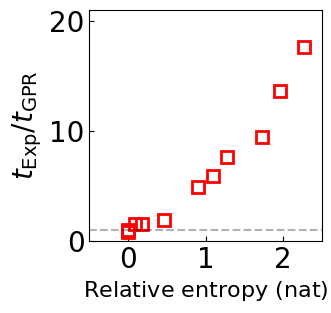

In [18]:
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(time_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(time_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')

ax.set_xticks([0,1,2])
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([0, 21])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$\mathrm{Relative\ entropy} \ \mathrm{(nat)}}$', fontsize=16)
ax.set_ylabel(r'$t_\mathrm{Exp}/t_\mathrm{GPR}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')

## 2D spectra

In [19]:
filename_list = [f'SDS_5mgmL_20C_4m_fbt_0_{i:0.0f}_Iqxqy.dat' for i in  np.concatenate([np.linspace(1, 9, 9), np.linspace(10, 30, 5), np.linspace(60, 120, 3), np.linspace(240, 720, 5)])]
label_list = [f'time_0_{i:0.0f}' for i in np.concatenate([np.linspace(1, 9, 9), np.linspace(10, 30, 5), np.linspace(60, 120, 3), np.linspace(240, 720, 5)])]
time_list = np.concatenate([np.linspace(1, 9, 9), np.linspace(10, 30, 5), np.linspace(60, 120, 3), np.linspace(240, 720, 5)])

data_2D_list = []

for i_file, filename in enumerate(filename_list):
    data = np.loadtxt('./data/EQSANS/SDS/'+filename, skiprows=4)
    data_2D_list.append(data)

0.117560833555319
0.11987888822


/tmp/ipykernel_1387585/3677914062.py:24: RuntimeWarning: invalid value encountered in log
  ax.pcolormesh(qx_grid, qy_grid, np.log(I_grid), cmap='viridis', vmax=np.log(1), vmin=np.log(0.01))


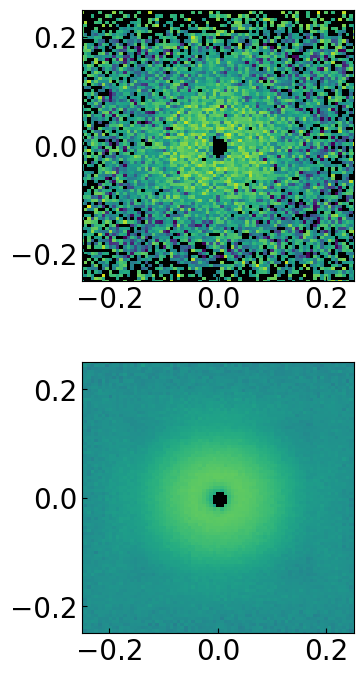

In [20]:
from scipy.interpolate import griddata

fig = plt.figure(figsize=(3.6, 7.2))

ax = plt.subplot(2, 1, 1)
i_time = 0
data = data_2D_list[i_time]
qx = data[:, 0]
qy = data[:, 1]
I = data[:, 2]
N_sum = np.sum(I[np.isfinite(I)])

# Create a grid of q values
qx_unique = np.unique(qx)
qy_unique = np.unique(qy)
qx_grid, qy_grid = np.meshgrid(qx_unique, qy_unique)
N_grids = len(qx_unique)*len(qy_unique)

# Interpolate the intensity values onto the grid
I_grid = griddata((qx, qy), I, (qx_grid, qy_grid), method='linear')
I_grid = I_grid#/N_sum*1e4
print(N_sum/1e4)

ax.pcolormesh(qx_grid, qy_grid, np.log(I_grid), cmap='viridis', vmax=np.log(1), vmin=np.log(0.01))
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xlim([-0.25, 0.25])
ax.set_ylim([-0.25, 0.25])
ax.set_facecolor('black')
# ax.set_xticks([-0.3, -0.15, 0, 0.15, 0.3])
# ax.set_yticks([-0.3, -0.15, 0, 0.15, 0.3])
ax.tick_params(direction='in', labelsize=20)
ax.set_aspect('equal')

ax = plt.subplot(2, 1, 2)
i_time = 21
data = data_2D_list[i_time]
qx = data[:, 0]
qy = data[:, 1]
I = data[:, 2]
N_sum = np.sum(I[np.isfinite(I)])
print(N_sum/1e4)

# Create a grid of q values
qx_unique = np.unique(qx)
qy_unique = np.unique(qy)
qx_grid, qy_grid = np.meshgrid(qx_unique, qy_unique)
N_grids = len(qx_unique)*len(qy_unique)

# Interpolate the intensity values onto the grid
I_grid = griddata((qx, qy), I, (qx_grid, qy_grid), method='linear')
I_grid = I_grid#/N_sum*1e4

ax.pcolormesh(qx_grid, qy_grid, np.log(I_grid), cmap='viridis', vmax=np.log(1), vmin=np.log(0.01))
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xlim([-0.25, 0.25])
ax.set_ylim([-0.25, 0.25])
ax.set_facecolor('black')
# ax.set_xticks([-0.3, -0.15, 0, 0.15, 0.3])
# ax.set_yticks([-0.3, -0.15, 0, 0.15, 0.3])
ax.tick_params(direction='in', labelsize=20)
ax.set_aspect('equal')

plt.tight_layout()